# Single-Object Detection

In this chapter, we will cover the following recipes:
* Exploratory data analysis
* Data transformation for object detection
* Creating custom datasets
* Creating the model
* Defining the loss, optimizer, and IOU metric
* Training and evaluation of the model
* Deploying the model

# Exploratory Data Analysis

1. To find the dataset, visit https://amd.grand-challenge.org/
2. Click on images and AMD labels, as highlighted in the following screenshot, to download the data:
3. Click on the Download button and then select Direct Download. The iChallenge-AMD-Training400.zip file will be downloaded. Move the .zip file to a folder named data in the same location as your code.
5. Extract the .zip file into a folder named data/Training400. The folder should contain another folder named AMD with 89 images, a folder named Non-AMD with 311 images, and an Excel file named Fovea_location.xlsx.
6. The Excel file contains the centroid locations of the fovea in the 400 images (89+311).

**NOTE**: Download data from this [link](http://ai.baidu.com/broad/download) instead.

Install seaborn with this command:
```
$ conda install -c anaconda seaborn
```

### 1. Let's begin by loading Fovea_location.xlsx and printing out its head:

In [1]:
import os
import pandas as pd

path_to_data = "./data/"

path_to_labels = os.path.join(path_to_data, "Training400",
                              "Fovea_location.xlsx")

# make sure to install xlrd
labels_df = pd.read_excel(path_to_labels, index_col="ID")
labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


### 2. Next, we print out the tail of the Excel file:

In [2]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
395,N0307.jpg,823.024991,690.210211
396,N0308.jpg,647.598978,795.653188
397,N0309.jpg,624.571803,755.694880
398,N0310.jpg,687.523044,830.449187
399,N0311.jpg,746.107631,759.623062


### 3. Then, we will show the scatter plot of the Fovea_X and Fovea_Y coordinates:

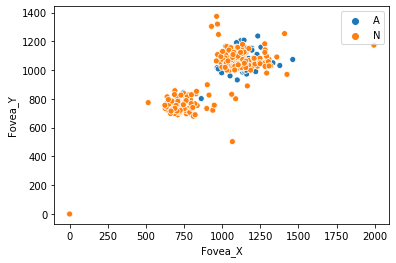

In [3]:
import seaborn as sns
%matplotlib inline

a_or_n = [img_num[0] for img_num in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'], 
                y = labels_df['Fovea_Y'],
                hue = a_or_n)

### 4. Next, we will show a few sample image. We will import the required packages and fix the random seed:

In [4]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt

# fix random seed
np.random.seed(2019)

# then we will se the plot parameters:
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
n_rows, n_cols = 2, 3

# then we will select a random set of image ids
img_name = labels_df["imgName"]
ids = labels_df.index
random_ids = np.random.choice(ids, n_rows * n_cols)
print(random_ids)

[ 73 371 160 294 217 191]


<Figure size 1080x648 with 0 Axes>

In [5]:
# Next, we will define a helper function to load an image and
# its labels from the local files:

def load_img_label(labels_df, id_):
    img_name = labels_df["imgName"]
    
    if img_name[id_][0] == "A":
        prefix = "AMD"
    else:
        prefix = "Non-AMD"
        
    full_path_to_img = os.path.join(path_to_data, "Training400",
                                    prefix, img_name[id_])

    img = Image.open(full_path_to_img)
    x = labels_df["Fovea_X"][id_]
    y = labels_df["Fovea_Y"][id_]
    label = (x, y)

    return img, label

In [6]:
# Next, we will define a helper function to show the image and
# label as a bounding box:

def show_img_label(img, label, w_h=(50, 50), thickness=2):
    w, h = w_h
    cx, cy = label
    draw = (ImageDraw.Draw(img))
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),
                   outline="green", width=thickness)
    plt.imshow(np.asarray(img))    

(2124, 2056) (1137.79551608168, 1150.60992139943)
(2124, 2056) (1020.11285409474, 1019.60122995928)
(2124, 2056) (986.937205962063, 1068.54715638874)
(1444, 1444) (728.790984719886, 731.020576268146)
(2124, 2056) (1003.73900361055, 1034.19661748445)
(1444, 1444) (771.730744824261, 826.702097928259)


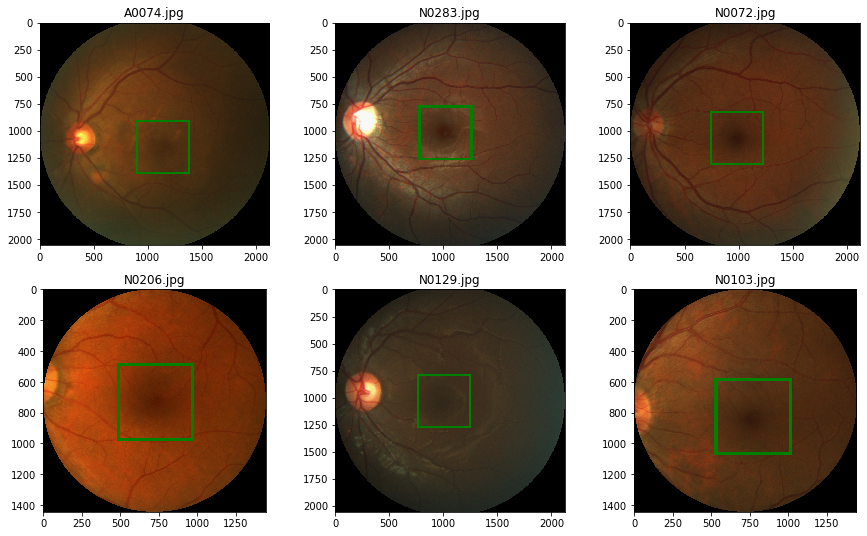

In [7]:
# Then, we will show the selected images together with the
# fovea bounding boxes:
for i, id_ in enumerate(random_ids):
    img, label = load_img_label(labels_df, id_)
    print(img.size, label)
    plt.subplot(n_rows, n_cols, i+1)
    show_img_label(img, label, w_h=(500, 500), thickness=20)
    plt.title(img_name[id_])

### 5. Next, we will collect the image widths and heights in two lists:

In [8]:
h_list, w_list = [], []

for id_ in ids:
    if img_name[id_][0] == "A":
        prefix = "AMD"
    else:
        prefix = "Non-AMD"

    full_path_to_img = os.path.join(path_to_data, "Training400",
                                    prefix, img_name[id_])
    try:
        img = Image.open(full_path_to_img)
        h, w = img.size
        h_list.append(h)
        w_list.append(w)
    except:
        print(full_path_to_img)
        print("File not available")

### 6. Then, we will plot the distributions of heights and widths:

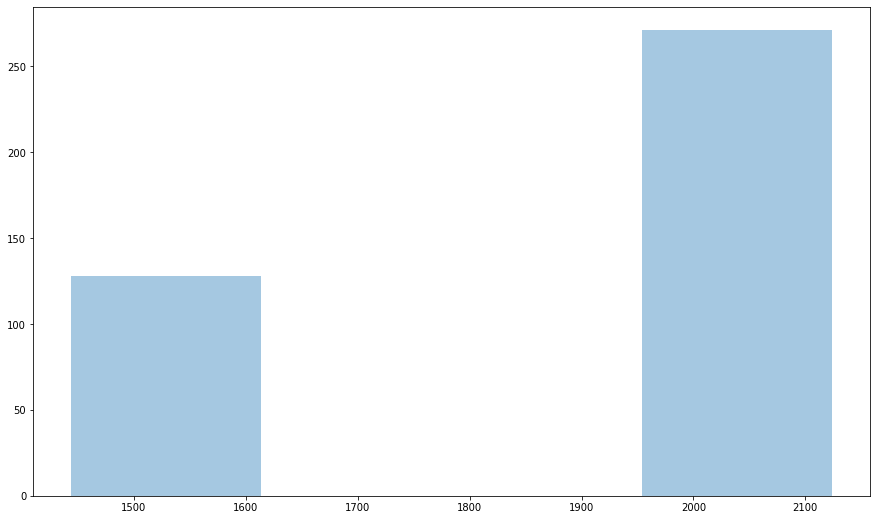

In [9]:
# Plot the distribution of the image heights as follows:

sns.distplot(a=h_list, kde=False)

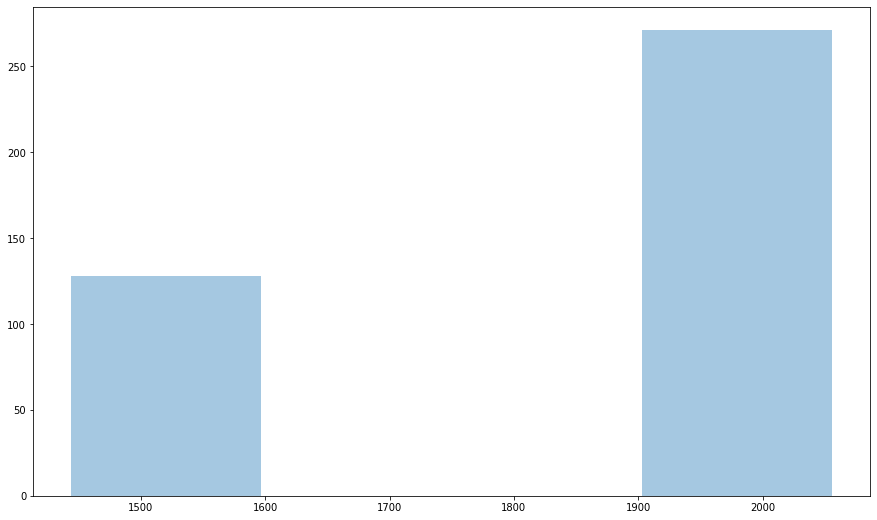

In [10]:
# Next, we will plot the distribution of the image widths
sns.distplot(a=w_list, kde=False)

# Data transformation for object detection

### 1. First, we will define a helper function to resize images:

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


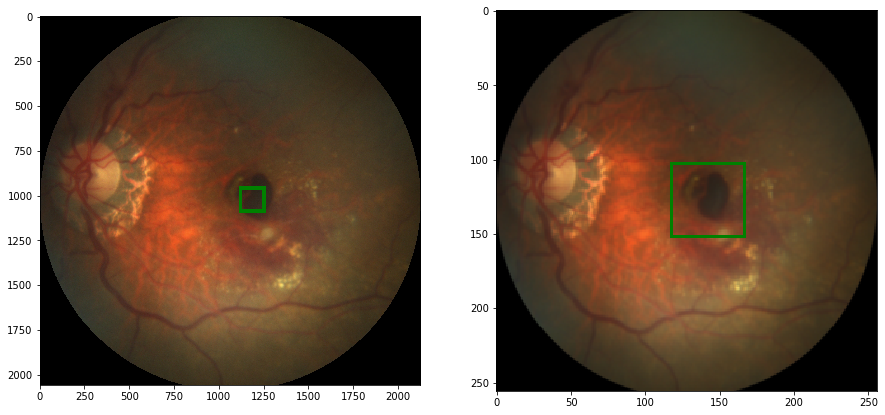

In [11]:
import torchvision.transforms.functional as TF

def resize_img_label(image, label=(0., 0.), target_size=(256, 256)):
    w_orig, h_orig = image.size
    w_target, h_target = target_size
    cx, cy = label
    image_new = TF.resize(image, target_size)
    label_new = cx/w_orig * w_target, cy/h_orig * h_target
    return image_new, label_new

# Let's try resizing an image using the preceding function:
img, label = load_img_label(labels_df, 1)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(150, 150), thickness=20)
plt.subplot(1, 2, 2)
show_img_label(img_r, label_r)

### 2. Next, we will define a helper function to randomly flip images horizontally:

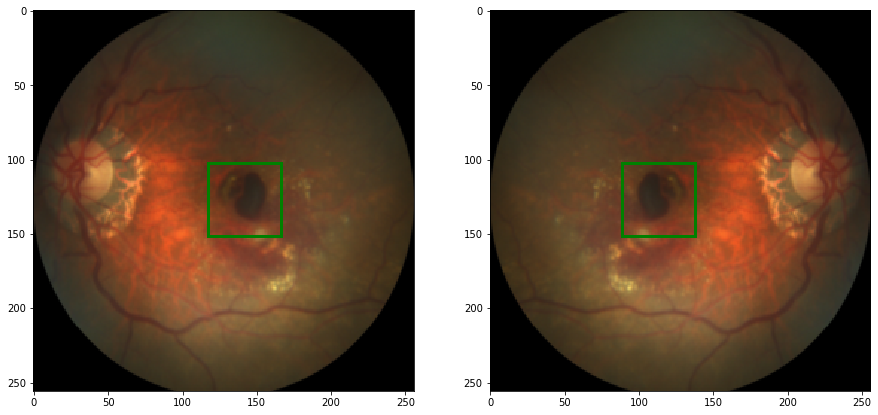

In [12]:
def random_hflip(image, label):
    w, h = image.size
    x, y = label
    
    image = TF.hflip(image)
    label = w-x, y
    return image, label

# Let's try flipping an image using the preceding function
img, label = load_img_label(labels_df, 1)
img_r, label_r = resize_img_label(img, label)
img_fh, label_fh = random_hflip(img_r, label_r)

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)
plt.subplot(1, 2, 2)
show_img_label(img_fh, label_fh)

### 3. Next, we will define a function to randomly flip images vertically:

In [13]:
def random_vflip(image, label):
    w, h = image.size
    x, y = label
    
    image = TF.vflip(image)
    label = x, w-y
    return image, label

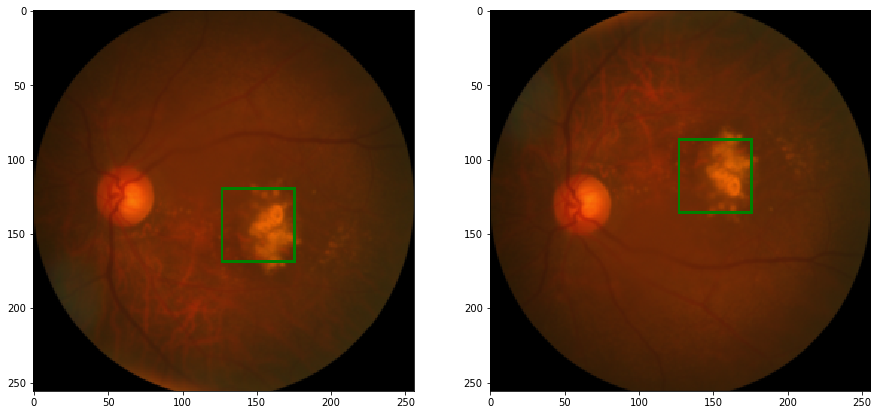

In [14]:
# Let's try flipping an image using the preceding function:
img, label = load_img_label(labels_df, 7)
img_r, label_r = resize_img_label(img, label)
img_fv, label_fv = random_vflip(img_r, label_r)

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)
plt.subplot(1, 2, 2)
show_img_label(img_fv, label_fv)

### 4. Next, we will define a helper function to randomly shift or translate images in either direction:

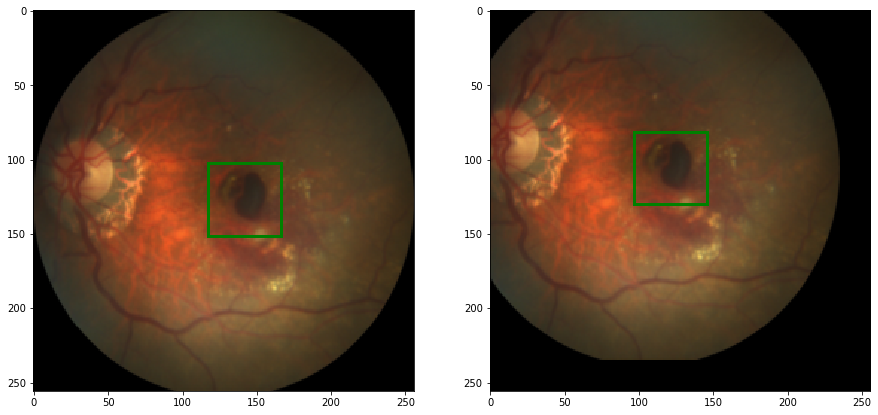

In [15]:
import numpy as np
np.random.seed(1)

def random_shift(image, label, max_translate=(0.2, 0.2)):
    w, h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label
    trans_coef = np.random.rand()*2 - 1
    w_t = int(trans_coef * max_t_w * w)
    h_t = int(trans_coef * max_t_h * h)
    
    image = TF.affine(image, translate=(w_t, h_t),
                      shear=0, angle=0, scale=1)
    label = cx+w_t, cy+h_t
    return image, label

# let's try translating an image using the random_shift function:
img, label = load_img_label(labels_df, 1)
img_r, label_r = resize_img_label(img, label)
img_t, label_t = random_shift(img_r,
                              label_r,
                              max_translate=(.5, .5))

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)
plt.subplot(1, 2, 2)
show_img_label(img_t, label_t)

### 5. Next, we will compose multiple transformations into one function to define transformer:

In [16]:
def transformer(image, label, params):
    image, label = resize_img_label(image, label,
                                    params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image, label)
    
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image, label)
        
    if random.random() < params["p_shift"]:
        image, label = random_shift(image, label,
                                    params["max_translate"])
        
#     if random.random() < params["p_brightness"]:
#         brightness_factor = 1 + (np.random.rand() * 2 - 1) * params["brightness_factor"]                        
#         image = TF.adjust_brightness(image, brightness_factor)
        
#     if random.random() < params["p_contrast"]:
#         contrast_factor = 1 + (np.random.rand() * 2 - 1) * params["contrast_factor"]                          
#         image = TF.adjust_contrast(image, contrast_factor)
        
#     if random.random() < params["p_gamma"]:
#         gamma = 1 + (np.random.rand() * 2 - 1) * params["gamma"]
#         image = TF.adjust_gamma(image, gamma)
        
#     if params["scale_label"]:
#         label = scale_label(label, params["target_size"])
        
    image = TF.to_tensor(image)
    
    return image, label

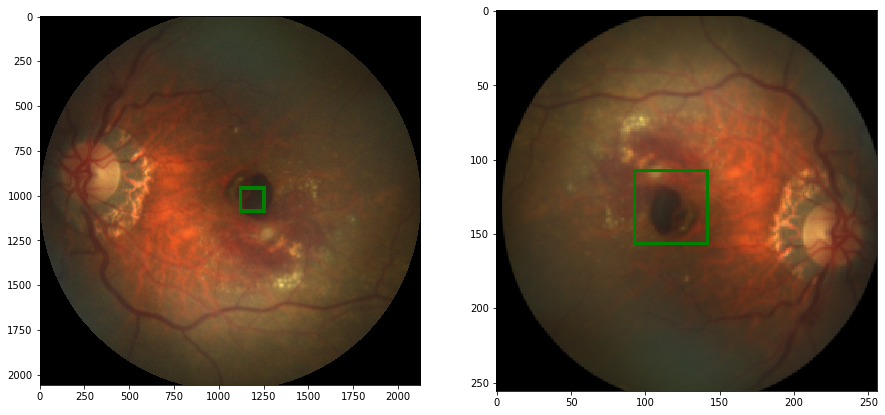

In [17]:
# let's try to transform an image using transformer
import random
np.random.seed(0)
random.seed(0)

img, label = load_img_label(labels_df, 1)

params = {
    "target_size": (256, 256),
    "p_hflip": 1.0,
    "p_vflip": 1.0,
    "p_shift": 1.0,
    "max_translate": (0.2, 0.2),
}

img_t, label_t = transformer(img, label, params)

# Then, we will show the original and transformed images
plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(150, 150),
               thickness=20)
plt.subplot(1, 2, 2)
show_img_label(TF.to_pil_image(img_t), label_t)

In [18]:
def transformer(image, label, params):
    image, label = resize_img_label(image, label,
                                    params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image, label)
    
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image, label)
        
    if random.random() < params["p_shift"]:
        image, label = random_shift(image, label,
                                    params["max_translate"])
        
    if random.random() < params["p_brightness"]:
        brightness_factor = 1 + (np.random.rand() * 2 - 1) * params["brightness_factor"]                        
        image = TF.adjust_brightness(image, brightness_factor)
        
    if random.random() < params["p_contrast"]:
        contrast_factor = 1 + (np.random.rand() * 2 - 1) * params["contrast_factor"]                          
        image = TF.adjust_contrast(image, contrast_factor)
        
    if random.random() < params["p_gamma"]:
        gamma = 1 + (np.random.rand() * 2 - 1) * params["gamma"]
        image = TF.adjust_gamma(image, gamma)
        
    if params["scale_label"]:
        label = scale_label(label, params["target_size"])
        
    image = TF.to_tensor(image)
    
    return image, label

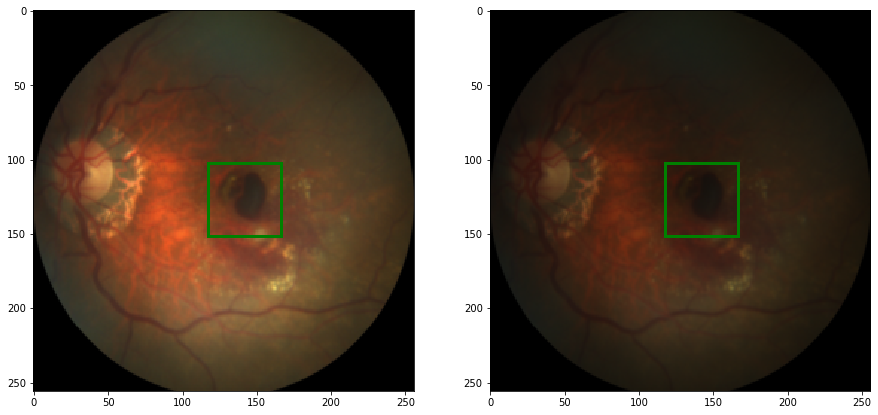

In [19]:
# we can create new images by adjusting the brightness:

img, label = load_img_label(labels_df, 1)

# resize image and label
img_r, label_r = resize_img_label(img, label)

# adjust brightness
img_t = TF.adjust_brightness(img_r, brightness_factor=0.5)
label_t = label_r

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)
plt.subplot(1, 2, 2)
show_img_label(img_t, label_t)

In [20]:
# similarly, we can create new images by adjusting the contrast
# and gamma correction

# brightness
img_t = TF.adjust_contrast(img_r, contrast_factor=0.4)

# gamma correction
img_t = TF.adjust_gamma(img_r, gamma=1.4)

In [21]:
# There is another transformation that we usually perform on the
# labels. In this transformation, we scale the labels to the range
# of [0,1] using the following function.

def scale_label(a, b):
    div = [ai/bi for ai, bi in zip(a,b)]
    return div

In [22]:
# let's try to transform an image using the latest transformer
# function
# load the image and label:
np.random.seed(0)
random.seed(0)

# load image and label
img, label = load_img_label(labels_df, 1)

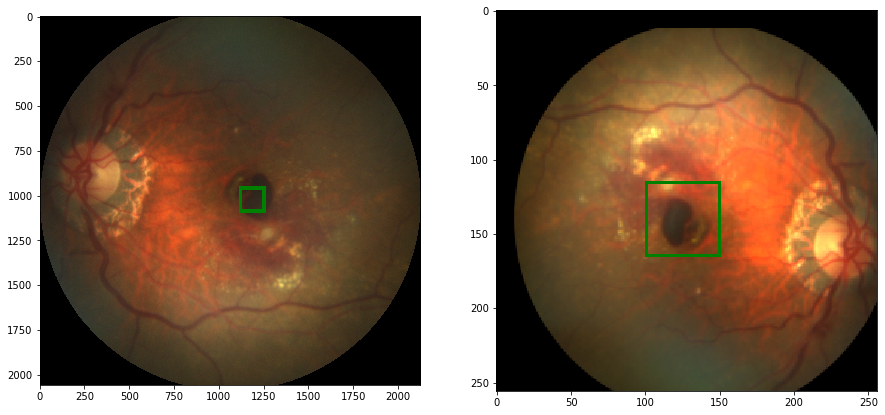

In [23]:
# set the transformation parameters and then apply the transformations

params = {
    "target_size": (256, 256),
    "p_hflip": 1.0,
    "p_vflip": 1.0,
    "p_shift": 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}

img_t, label_t = transformer(img, label, params)

# Then show the original and transformed images by executing
# the following code snippet
plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(150, 150), thickness=20)
plt.subplot(1, 2, 2)
show_img_label(TF.to_pil_image(img_t), label_t)

In [24]:
# Lastly to rescale the labels back to the image size
def rescale_label(a, b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

Other data augmenters:
- Augmenter: https://github.com/mdbloice/Augmentor
- imgaug: https://github.com/aleju/imgaug
- Albumentations: https://github.com/albu/albumentations

# Creating custom datasets

### 1. Let's define a custom dataset class. First, we will load the required packages:

In [25]:
from torch.utils.data import Dataset
from PIL import Image

# then, we will define the bulk of the dataset class:

In [26]:
class AMD_dataset(Dataset):
    def __init__(self, path_to_data, transform, trans_params):
        pass
    
    def __len__(self):
        # return size of dataset
        return len(self.labels)
    
    def __getitem__(self, idx):
        pass

In [27]:
def __init__(self, path_to_data, transform, trans_params):
    path_to_labels = os.path.join(path_to_data, "Training400",
                                  "Fovea_location.xlsx")
    
    labels_df = pd.read_excel(path_to_labels, index_col="ID")
    self.labels = labels_df[["Fovea_X", "Fovea_Y"]].values
    
    self.img_name = labels_df["imgName"]
    self.ids = labels_df.index
    
    self.full_path_to_img = [0] * len(self.ids)
    
    for id_ in self.ids:
        if self.img_name[id_][0] == "A":
            prefix = "AMD"
        else:
            prefix = "Non-AMD"
            
        self.full_path_to_img[id_-1] = os.path.join(path_to_data,
                                                    "Training400",
                                                    prefix,
                                                    self.img_name[id_])
    self.transform = transform
    self.trans_params = trans_params

In [28]:
def __getitem__(self, idx):
    # load PIL image
    image = Image.open(self.full_path_to_img[idx])
    label = self.labels[idx]
    
    # transform to tensor
    image, label = self.transform(image, label, self.trans_params)
    
    return image, label

In [29]:
# then, we will override the dataset class functions
AMD_dataset.__init__=__init__
AMD_dataset.__getitem__=__getitem__

### 2. Next, we will create two objects of AMD_dataset:

In [30]:
# first, we will define the transformation parameters for the
# training dataset

trans_params_train = {
    "target_size": (256, 256),
    "p_hflip": 0.5,
    "p_vflip": 0.5,
    "p_shift": 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True,
}

In [31]:
# then, we will define the transformation parameters for the
# validation dataset
trans_params_val = {
    "target_size": (256, 256),
    "p_hflip": 0.0,
    "p_vflip": 0.0,
    "p_shift": 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "scale_label": True,
}

In [32]:
# then, two objects of the AMD_dataset class will be defined
amd_ds1 = AMD_dataset(path_to_data, transformer,
                      trans_params_train)
amd_ds2 = AMD_dataset(path_to_data, transformer,
                      trans_params_val)

### 3. Next, we will split the dataset into training and validation sets

In [33]:
# first, we will split the image indices into two groups
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-" * 20)
    print(len(val_index))

319
--------------------
80


In [34]:
# then, we will define the training and validation datasets:
from torch.utils.data import Subset

train_ds = Subset(amd_ds1, train_index)
print(len(train_ds))

val_ds = Subset(amd_ds2, val_index)
print(len(val_ds))

319
80


### 4. Let's now show a sample image from train_ds and val_ds

In [35]:
# first, we will import the required packages:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

In [37]:
# then, we will define a function to show a tensor image and
# its label
def show(img, label=None):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    print(img.shape[1:])
    if label is not None:
        print(label)
        label = rescale_label(label, img.shape[1:])
        print(label)
        x, y = label
        plt.plot(x, y, 'b+', markersize=20)
  

torch.Size([256, 256])
[0.6313199724798118, 0.5150695423324902]
[161.6179129548318, 131.8578028371175]


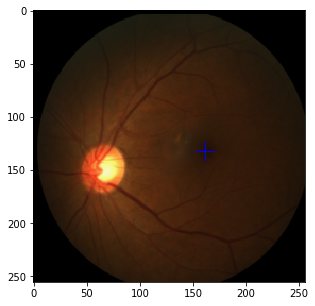

In [38]:
# then, we will show a sample image from train_ds
plt.figure(figsize=(5,5))

for img, label in train_ds:
    show(img, label)
    break

### 5. Next, we will define two data loaders for the training and validation datasets:

In [38]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

### 6. Let's get a batch of data from train_dl:

In [39]:
for img_b, label_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(label_b)
    break

torch.Size([8, 3, 256, 256]) torch.float32
[tensor([0.4695, 0.5802, 0.4873, 0.4841, 0.5212, 0.6869, 0.5219, 0.6403]), tensor([0.4824, 0.6128, 0.4964, 0.5166, 0.5021, 0.6800, 0.5009, 0.7179])]


In [40]:
# We need to convert the list to a tensor
import torch

# extract a batch from training data
for img_b, label_b in train_dl:
    print(img_b.shape, img_b.dtype)
    
    # convert list to tensor
    label_b = torch.stack(label_b, 1)
    label_b = label_b.type(torch.float32)
    print(label_b.shape, label_b.dtype)
    break

torch.Size([8, 3, 256, 256]) torch.float32
torch.Size([8, 2]) torch.float32


### 7. Similarly, we will get a batch from val_dl:

In [41]:
for img_b, label_b in val_dl:
    print(img_b.shape, img_b.dtype)
    
    # convert to tensor
    label_b = torch.stack(label_b, 1)
    label_b = label_b.type(torch.float32)
    print(label_b.shape, label_b.dtype)
    break

torch.Size([16, 3, 256, 256]) torch.float32
torch.Size([16, 2]) torch.float32


# Creating the model

In this model, we will use the skip connectection technique introduced in the ResNet paper.

### 1. Let's implement the model class. First, we will load the packages:

In [42]:
import torch.nn as nn
import torch.nn.functional as F

# then, we will define the bulk of the model class:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    def forward(self, x):
        return x

In [43]:
# Next, we will define the __init__ function:
def __init__(self, params):
    super(Net, self).__init__()
    
    c_in, h_in, w_in = params["input_shape"]
    init_f = params["initial_filters"]
    num_outputs = params["num_outputs"]
    
    self.conv1 = nn.Conv2d(c_in, init_f, kernel_size=3,
                           stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f + c_in, 2 * init_f,
                           kernel_size=3, stride=1,
                           padding=1)
    self.conv3 = nn.Conv2d(3 * init_f + c_in, 4 * init_f,
                           kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7 * init_f + c_in, 8 * init_f,
                           kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15 * init_f + c_in, 16 * init_f,
                           kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16 * init_f, num_outputs)

In [44]:
def forward(self, x):
    identity = F.avg_pool2d(x, 4, 4)
    
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity = F.avg_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity = F.avg_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity = F.avg_pool2d(x, 2, 2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    x = F.relu(self.conv5(x))
    
    x = F.adaptive_avg_pool2d(x, 1)
    x = x.reshape(x.size(0), -1)
    x = x.reshape(x.size(0), -1)
    
    x = self.fc1(x)
    
    return x

In [45]:
# then, we will override the Net class functions
Net.__init__=__init__
Net.forward=forward

### 2. Let's now define an object of the Net class:

In [48]:
params_model = {
    "input_shape": (3, 256, 256),
    "initial_filters": 16,
    "num_outputs": 2,
}

model = Net(params_model)

In [49]:
# then we will move the model to the Compute Unified Device
# Architecture (CUDA) device:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)

In [50]:
# print the model
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


# Defining the loss, optimizer, and IOU metric

The common loss functions for detection tasks are the mean square error (MSE) and smoothed-L1 loss.

- Smoothed-L1 loss uses a squared term if the absolute element-wise error falls below 1, and an L1 term otherwise.
    - It is less sensistive to outliers than the MSE and in some cases prevents exploding gradients.

### 1. First, we will define the loss function:

In [51]:
loss_func = nn.SmoothL1Loss(reduction="sum")

In [52]:
# let's try out the loss with known values:
n, c = 8, 2
y = 0.5 * torch.ones(n, c, requires_grad=True)
print(y.shape)

target = torch.zeros(n, c, requires_grad=False)
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

y = 2 * torch.ones(n, c, requires_grad=True)
target = torch.zeros(n, c, requires_grad=False)
loss = loss_func(y, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8, 2])
2.0
24.0


### 2. Next, we will define the optimizer:

In [72]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

In [73]:
# then, we will define a helper function to read the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
current_lr = get_lr(opt)
print('current lr = {}'.format(current_lr))

current lr = 0.0003


### 3. Next, we will define a learning rate schedule:

In [74]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5,
                                 patience=20, verbose=1)

In [75]:
# let's try it out:
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


### 4. Next, we will define a function to compute the IOU for a batch of data:

In [63]:
# first, we wil define a helper function to convert coordinates
# to a bounding box
def cxcy2bbox(cxcy, w=50./256, h=50./256):
    # define two new tensors for w and h
    w_tensor = torch.ones(cxcy.shape[0], 1, device=cxcy.device) * w
    h_tensor = torch.ones(cxcy.shape[0], 1, device=cxcy.device) * h
    
    # extract cx and cy
    cx = cxcy[:, 0].unsqueeze(1)
    cy = cxcy[:, 1].unsqueeze(1)
    
    # concat cx, cy, w andh
    boxes = torch.cat((cx, cy, w_tensor, h_tensor), -1)
    
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,
                      boxes[:, :2] + boxes[:, 2:]/2), 1)

In [64]:
# let's try out the function
torch.manual_seed(0)

cxcy = torch.rand(1, 2)
print("center:", cxcy * 256)

bb = cxcy2bbox(cxcy)
print("bounding box", bb*256)

center: tensor([[127.0417, 196.6648]])
bounding box tensor([[102.0417, 171.6648, 152.0417, 221.6648]])


In [76]:
# next we will define the metric function
import torchvision
def metrics_batch(output, target):
    output = cxcy2bbox(output)
    target = cxcy2bbox(target)
    
    iou = torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()

In [77]:
# let's try it out on known values
n, c = 8, 2
target = torch.rand(n, c, device=device)
target = cxcy2bbox(target)
metrics_batch(target, target)

8.0

### 5. Next, we will define the loss_batch function:

In [79]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item(), metric_b

In [80]:
# let's now try the loss_batch function on known values

In [81]:
for xb, label_b in train_dl:
    label_b = torch.stack(label_b, 1)
    label_b = label_b.type(torch.float32)
    label_b = label_b.to(device)
    
    l, m = loss_batch(loss_func, label_b, label_b)
    print(l, m)
    break

0.0 8.0


# Training and evaluation of the model

### 1. First, we will define a loss_epoch helper function:

In [82]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False,
               opt=None):
    running_loss = 0.0
    running_metric = 0.0
    
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        # convert to tensor
        yb = torch.stack(yb, 1)
        yb = yb.type(torch.float32).to(device)
        
        # get model output
        output = model(xb.to(device))
        
        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss += loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric += metric_b
            
    # average loss value
    loss = running_loss / float(len_data)
    
    # average metric value
    metric = running_metric / float(len_data)
    
    return loss, metric

### 2. Then, we will define a train_val function:

In [83]:
import copy

def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    
    # history of loss values in each epoch
    loss_history = {
        "train": [],
        "val": [],
    }
    
    # history of metric values in each epoch
    metric_history = {
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_weights = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch,
                                                  num_epochs -1,
                                                  current_lr))
        
        # train the model
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func,
                                              train_dl, sanity_check,
                                              opt)
        
        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func,
                                              val_dl, sanity_check)
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
            
        print("train loss: %.6f, accuracy: %.2f" % (train_loss,
                                                    100*train_metric))
        print("val loss: %.6f, accuracy: %.2f" % (val_loss,
                                                  100*val_metric))
        print("-"*10)
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history

### 3. Let's now train the model by calling the train_val function:

In [86]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [87]:
loss_func = nn.SmoothL1Loss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=1e-4)

lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5,
                                 patience=20, verbose=1)

path2models = "./models/"
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models + "weights_smoothl1.pt",
}

model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr=0.0001
Copied best model weights!
train loss: 0.014431, accuracy: 31.12
val loss: 0.005929, accuracy: 46.92
----------
Epoch 1/99, current lr=0.0001
Copied best model weights!
train loss: 0.012008, accuracy: 36.06
val loss: 0.004428, accuracy: 64.22
----------
Epoch 2/99, current lr=0.0001
train loss: 0.010244, accuracy: 35.36
val loss: 0.006527, accuracy: 34.95
----------
Epoch 3/99, current lr=0.0001
train loss: 0.009540, accuracy: 39.21
val loss: 0.006634, accuracy: 35.25
----------
Epoch 4/99, current lr=0.0001
train loss: 0.009953, accuracy: 40.35
val loss: 0.005211, accuracy: 56.48
----------
Epoch 5/99, current lr=0.0001
train loss: 0.007788, accuracy: 42.07
val loss: 0.005321, accuracy: 46.92
----------
Epoch 6/99, current lr=0.0001
train loss: 0.007639, accuracy: 42.44
val loss: 0.005783, accuracy: 45.87
----------
Epoch 7/99, current lr=0.0001
train loss: 0.008085, accuracy: 41.71
val loss: 0.004889, accuracy: 56.65
----------
Epoch 8/99, current lr=0.0

train loss: 0.006234, accuracy: 51.32
val loss: 0.005274, accuracy: 49.19
----------
Epoch 70/99, current lr=2.5e-05
train loss: 0.006353, accuracy: 49.78
val loss: 0.005482, accuracy: 48.35
----------
Epoch 71/99, current lr=2.5e-05
train loss: 0.006486, accuracy: 50.07
val loss: 0.004562, accuracy: 59.75
----------
Epoch 72/99, current lr=2.5e-05
train loss: 0.006322, accuracy: 50.23
val loss: 0.005007, accuracy: 53.26
----------
Epoch 73/99, current lr=2.5e-05
train loss: 0.006370, accuracy: 52.94
val loss: 0.005214, accuracy: 50.39
----------
Epoch 74/99, current lr=2.5e-05
Epoch    75: reducing learning rate of group 0 to 1.2500e-05.
Loading best model weights!
train loss: 0.005997, accuracy: 50.04
val loss: 0.004483, accuracy: 62.44
----------
Epoch 75/99, current lr=1.25e-05
train loss: 0.007359, accuracy: 46.31
val loss: 0.005488, accuracy: 44.39
----------
Epoch 76/99, current lr=1.25e-05
train loss: 0.006851, accuracy: 47.54
val loss: 0.005065, accuracy: 49.79
----------
Epoc

### 4. Next, we will plot the training and validation loss:

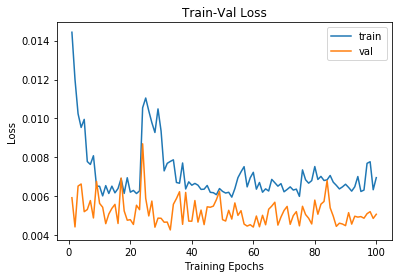

In [89]:
num_epochs = params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

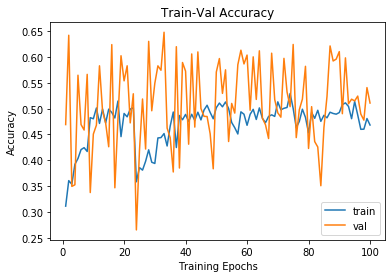

In [90]:
# Next, we will plot the IOU progress
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()